In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import datetime
import numpy as np
import torch
import torch.nn.functional as F

torch.autograd.set_detect_anomaly(True)
# torch.set_default_dtype(torch.float32)

import mediapy as mpy
from tqdm.auto import tqdm
from IPython.display import clear_output, display
import matplotlib.pyplot as plt
import wandb

from nca_model import SimpleNCA
from utils import nca_out_to_vids, tonp, save_model, load_latest_model, nca_cmap, pad_to, nca_clamp
from data import (
    MNISTPatternGenerator,
    MNISTPatternPool,
    generate_radial_circles_pattern,
    generate_canonical_mnist_digits,
)

In [4]:
device = "cuda"
num_classes = 10
channs = 16
bs = 16
S = 80
lr = 0.0008
pool_size = 64
pool_replacement = 0.8

In [5]:
# with open(".checkpoints/nca-80-radial/nca-45250-[2025-05-06-18-27-08].pkl", "rb") as fp:
#     loaded_nca = torch.load(fp).to(device)

with open(".checkpoints/nca-80-radial/nca-3000-[2025-05-07-15-51-03].pkl", "rb") as fp:
    loaded_nca = torch.load(fp).to(device)

In [12]:
rollouts = []
with torch.inference_mode():
    item = test_gen.ds[0]
    inp = item["inp"].unsqueeze(0).to(device)
    out_pred = loaded_nca(inp, steps=80)
    rollout = tonp(out_pred[:, 0, 0])

In [13]:
rollout.shape

(81, 80, 80)

,,,

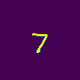
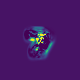
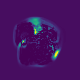
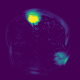

In [14]:
mpy.show_images([rollout[i] for i in [0, 10, 20, 30]], cmap="viridis", width=150, vmin=0, vmax=0.8)

## Test CLF

In [15]:
pattern.shape

torch.Size([10, 80, 80])

""

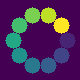

In [16]:
screen = np.zeros((80, 80))
for i in range(10):
    screen[pattern[i] == 1] = i + 1
    
mpy.show_image(screen, cmap="viridis", width=150)

In [32]:
with open(".checkpoints/nca-80-radial/nca-45250-[2025-05-06-18-27-08].pkl", "rb") as fp:
    loaded_nca = torch.load(fp).to(device)
    
# with open(".checkpoints/nca-80-radial/nca-49750-[2025-05-07-22-16-01].pkl", "rb") as fp:
#     loaded_nca = torch.load(fp).to(device)

In [ ]:
pattern = generate_radial_circles_pattern(S, num_classes)
test_gen = MNISTPatternGenerator(
    is_train=False,
    channs=channs,
    pattern=pattern,
    bs=1,
    loop_forever=False,
    shuffle=False,
)

test_recs = []
for batch in tqdm(test_gen):
    with torch.inference_mode():
        inp, out_gt = batch["inp"], batch["out"]
        out_gt = out_gt.to(device)[:, 0]
        out_pred = loaded_nca(inp.to(device), steps=30)
        last_frame = out_pred[-1][:, 0]
        loss = F.mse_loss(last_frame, out_gt)
        probs = np.array([
            (pattern[c] * last_frame[0].cpu()).mean().item()
            for c in range(num_classes)
        ])
        pred = probs.argmax()

        test_recs.append({
            "label": batch["label"].item(),
            "loss": loss.item(),
            "probs": probs,
            "prob": probs[pred],
            "pred": pred,
        })

  0%|          | 0/10000 [00:00<?, ?it/s]

In [23]:
import pandas as pd
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

In [24]:
test_df = pd.DataFrame(test_recs).reset_index()
test_df.head()

,index,label,loss,probs,prob,pred
0,0,7,0.013767,"[0.000224623779868125, 0.005583323012579058, 0...",0.014641,7
1,1,2,0.011330,"[0.00010043571441201493, 0.0009344622114076628...",0.017586,2
2,2,1,0.016646,"[0.00017871618925710208, 0.009578664914297406,...",0.009579,1
3,3,0,0.022612,"[0.008253411672703805, 0.00012056506129738409,...",0.009064,6
4,4,4,0.016515,"[-0.00016923524868616368, 0.004442841053169104...",0.010896,4


In [25]:
(test_df["pred"] == test_df["label"]).mean()

0.8192

In [134]:
print(classification_report(test_df["label"], test_df["pred"]))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       980
           1       0.85      0.94      0.89      1135
           2       0.89      0.92      0.91      1032
           3       0.85      0.89      0.87      1010
           4       0.78      0.91      0.84       982
           5       0.89      0.87      0.88       892
           6       0.89      0.92      0.91       958
           7       0.95      0.83      0.89      1028
           8       0.87      0.79      0.83       974
           9       0.85      0.72      0.78      1009

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



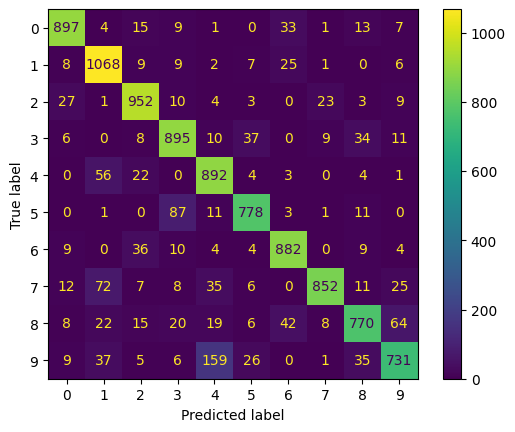

In [135]:
ConfusionMatrixDisplay.from_predictions(test_df["label"], test_df["pred"])

## Test Good Example

In [136]:
grouped = []
for i in range(num_classes):
    item = test_df.groupby("label").get_group(i).sort_values("loss").iloc[0]
    grouped.append(item.to_dict())

group_ids = [int(g["index"]) for g in grouped]

In [137]:
rollouts = []
with torch.inference_mode():
    for idx in tqdm(group_ids):
        item = test_gen.ds[idx]
        inp = item["inp"].unsqueeze(0).to(device)
        out_pred = loaded_nca(inp, steps=80)
        rollout = tonp(out_pred[:, 0, 0])
        rollouts.append(rollout)

  0%|          | 0/10 [00:00<?, ?it/s]

,,,,,,,,,

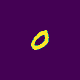
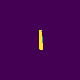
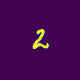
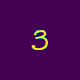
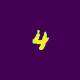
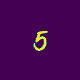
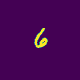
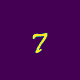
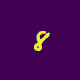
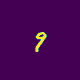

,,,,,,,,,

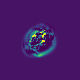
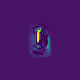
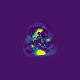
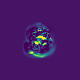
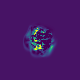
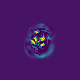
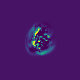
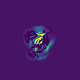
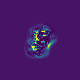
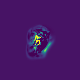

,,,,,,,,,

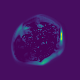
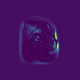
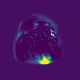
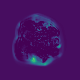
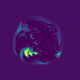
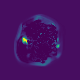
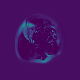
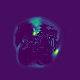
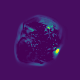
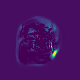

,,,,,,,,,

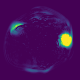
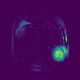
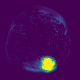
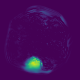
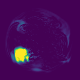
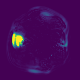
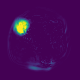
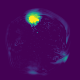
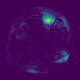
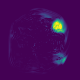

,,,,,,,,,

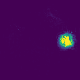
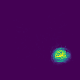
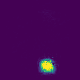
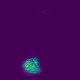
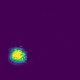
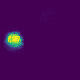
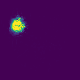
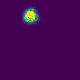
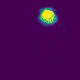
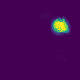

,,,,,,,,,

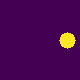
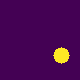
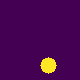
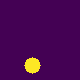
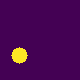
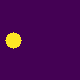
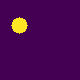
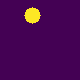
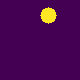
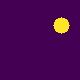

In [138]:
for i in [0, 10, 20, 30, -1]:
    mpy.show_images([r[i] for r in rollouts], cmap="viridis", width=100, vmin=0, vmax=0.8)

mpy.show_images(
    [np.array(test_gen.pattern[i]) for i, r in enumerate(rollouts)],
    cmap="viridis", width=100, vmin=0, vmax=1,
)

,,,,,

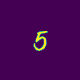
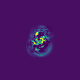
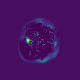
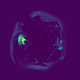
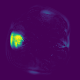
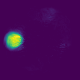

In [160]:
mpy.show_images(rollouts[5][[0, 8, 16, 24, 32, 40]], cmap="viridis", width=150, vmin=0, vmax=1)

In [168]:
rollout = rollouts[5]
probs_in_time = []
for r in rollout:
    probs = np.array([
        (pattern[c] * r).mean().item()
        for c in range(num_classes)
    ])
    probs_in_time.append(probs.tolist())
    
probs_in_time = np.array(probs_in_time)

In [170]:
probs_in_time.shape

(81, 10)

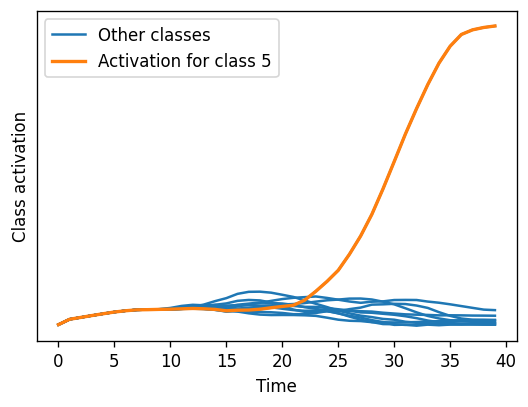

In [252]:
fig, ax = plt.subplots(dpi=120, figsize=(5, 3.5))

for c in range(num_classes - 1):
    plt.plot(probs_in_time[:40, c], c="tab:blue")

plt.plot(probs_in_time[:40, num_classes - 1], c="tab:blue", label="Other classes")


ax.plot(probs_in_time[:40, 5], c="tab:orange", linewidth=2, label="Activation for class 5")
ax.set_xlabel("Time")
ax.set_ylabel("Class activation")
plt.tight_layout()
plt.legend()
# plt.xticks([])
plt.yticks([])
plt.show()

,,,,,,,,,

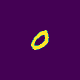
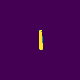
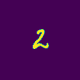
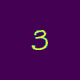
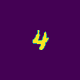
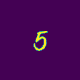
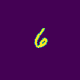
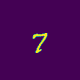
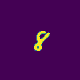
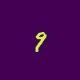

In [81]:
mpy.show_videos([
    mpy.to_rgb(r, cmap="viridis", vmin=0, vmax=1) for r in rollouts],
    width=150,
    codec="gif",
    fps=25
)

## Test Bad Example

  0%|          | 0/10 [00:00<?, ?it/s]

,,,,,,,,,

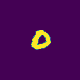
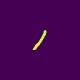
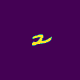
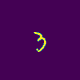
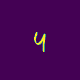
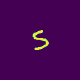
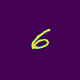
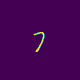
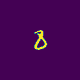
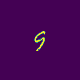

,,,,,,,,,

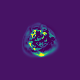
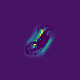
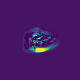
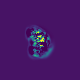
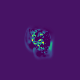
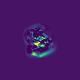
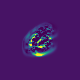
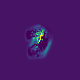
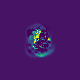
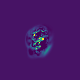

,,,,,,,,,

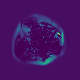
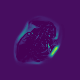
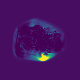
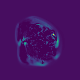
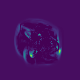
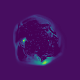
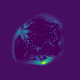
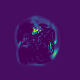
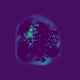
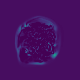

,,,,,,,,,

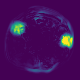
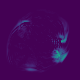
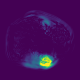
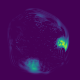
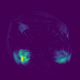
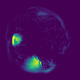
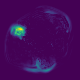
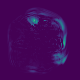
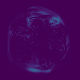
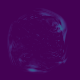

,,,,,,,,,

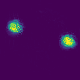
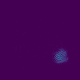
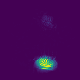
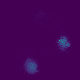
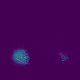
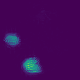
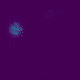
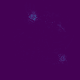
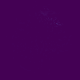
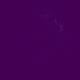

,,,,,,,,,

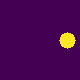
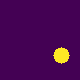
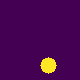
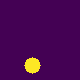
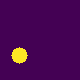
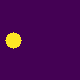
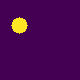
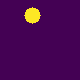
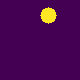
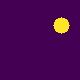

In [88]:
grouped = []
for i in range(num_classes):
    item = test_df.groupby("label").get_group(i).sort_values("loss").iloc[810]
    grouped.append(item.to_dict())

group_ids = [int(g["index"]) for g in grouped]

rollouts = []
with torch.inference_mode():
    for idx in tqdm(group_ids):
        item = test_gen.ds[idx]
        inp = item["inp"].unsqueeze(0).to(device)
        out_pred = loaded_nca(inp, steps=80)
        rollout = tonp(out_pred[:, 0, 0])
        rollouts.append(rollout)
        
for i in [0, 10, 20, 30, -1]:
    mpy.show_images([r[i] for r in rollouts], cmap="viridis", width=100, vmin=0, vmax=0.8)

mpy.show_images(
    [np.array(test_gen.pattern[i]) for i, r in enumerate(rollouts)],
    cmap="viridis", width=100, vmin=0, vmax=1,
)

,,,,,,,,,

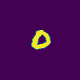
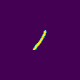
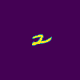
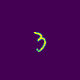
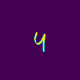
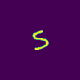
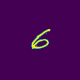
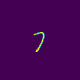
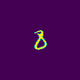
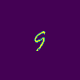

In [89]:
mpy.show_videos([
    mpy.to_rgb(r, cmap="viridis", vmin=0, vmax=1) for r in rollouts],
    width=150,
    codec="gif",
    fps=25
)

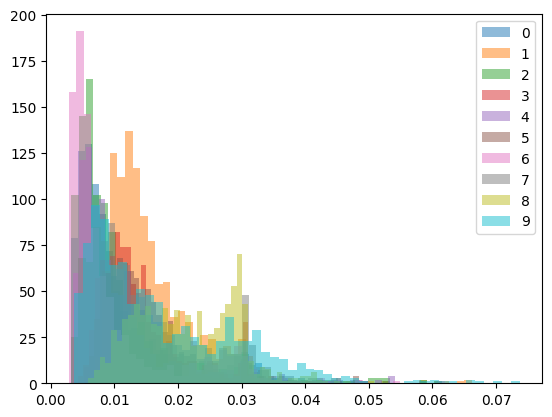

In [90]:
for c in range(num_classes):
    losses = test_df[test_df["label"] == c]["loss"]
    plt.hist(losses, bins=50, alpha=0.5, label=c)
plt.legend()

## First-last frame

In [92]:
frames = []
for i in tqdm(range(num_classes)):
    vs = test_df.groupby("label").get_group(i).sort_values("loss")
    item = vs.iloc[[0, 500, -5]]
    it = {k: list(v.values()) for k, v in item.to_dict().items()}

    last_frames = []
    with torch.inference_mode():
        for idx in it["index"]:
            item = test_gen.ds[idx]
            inp = item["inp"].unsqueeze(0).to(device)
            out_pred = loaded_nca(inp, steps=100)
            last_frame = tonp(out_pred[-1, 0, 0])
            first_frame = tonp(out_pred[0, 0, 0])

            last_frames.append(first_frame)
            last_frames.append(last_frame)

    frames.append(last_frames)

  0%|          | 0/10 [00:00<?, ?it/s]

,,,,,,,,,

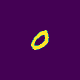
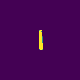
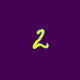
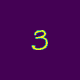
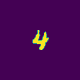
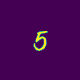
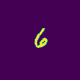
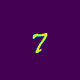
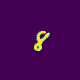
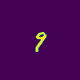

,,,,,,,,,

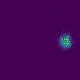
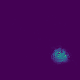
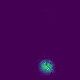
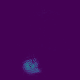
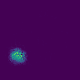
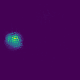
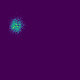
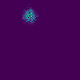
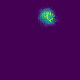
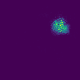

,,,,,,,,,

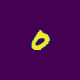
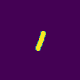
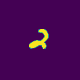
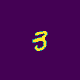
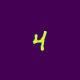
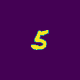
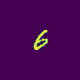
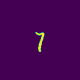
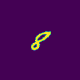
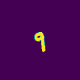

,,,,,,,,,

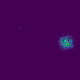
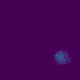
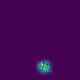
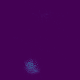
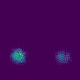
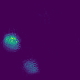
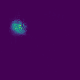
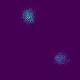
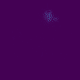
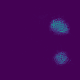

,,,,,,,,,

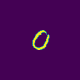
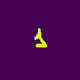
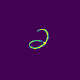
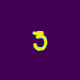
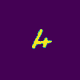
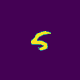
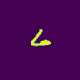
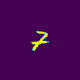
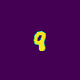
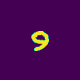

,,,,,,,,,

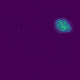
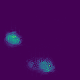
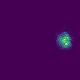
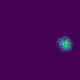
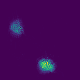
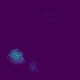
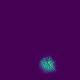
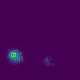
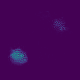
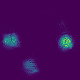

In [94]:
for i in range(len(frames[0])):
    mpy.show_images([fs[i] for fs in frames], cmap="viridis", width=100, vmin=0, vmax=1)

## Train CLF

In [96]:
pattern = generate_radial_circles_pattern(S, num_classes)
train_gen = MNISTPatternGenerator(
    is_train=True,
    channs=channs,
    pattern=pattern,
    bs=1,
    loop_forever=False,
    shuffle=False,
)

train_recs = []
for batch in tqdm(train_gen):
    with torch.inference_mode():
        inp, out_gt = batch["inp"], batch["out"]
        out_gt = out_gt.to(device)[:, 0]
        out_pred = loaded_nca(inp.to(device), steps=40)
        last_frame = out_pred[-1][:, 0]
        loss = F.mse_loss(last_frame, out_gt)
        probs = np.array([
            (pattern[c] * last_frame[0].cpu()).mean().item()
            for c in range(num_classes)
        ])
        pred = probs.argmax()

        train_recs.append({
            "label": batch["label"].item(),
            "loss": loss.item(),
            "probs": probs,
            "prob": probs[pred],
            "pred": pred,
        })

  0%|          | 0/60000 [00:00<?, ?it/s]

In [97]:
train_df = pd.DataFrame(train_recs).reset_index()
train_df.head()

,index,label,loss,probs,prob,pred
0,0,5,0.043408,"[-8.480773612973281e-07, -1.7298311067861505e-...",0.015425,3
1,1,0,0.003602,"[0.02523347517941147, 0.0005038118220181786, -...",0.025233,0
2,2,4,0.026494,"[-9.542857056658249e-05, 0.009310474384692497,...",0.009310,1
3,3,1,0.012985,"[-5.26094716769876e-05, 0.011494561342988163, ...",0.011495,1
4,4,9,0.010263,"[-8.393517393415095e-05, 0.003349715769145405,...",0.016401,9


In [98]:
(train_df["pred"] == train_df["label"]).mean()

0.8651

In [99]:
print(classification_report(train_df["label"], train_df["pred"]))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92      5923
           1       0.84      0.94      0.89      6742
           2       0.87      0.92      0.90      5958
           3       0.83      0.87      0.85      6131
           4       0.76      0.90      0.83      5842
           5       0.90      0.85      0.88      5421
           6       0.89      0.93      0.91      5918
           7       0.96      0.84      0.89      6265
           8       0.84      0.78      0.81      5851
           9       0.86      0.70      0.77      5949

    accuracy                           0.87     60000
   macro avg       0.87      0.86      0.86     60000
weighted avg       0.87      0.87      0.86     60000



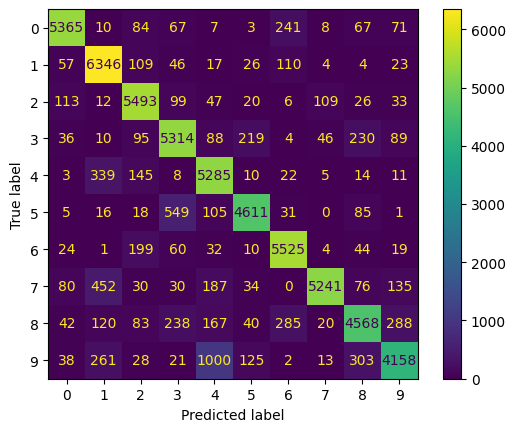

In [100]:
ConfusionMatrixDisplay.from_predictions(train_df["label"], train_df["pred"])